<a href="https://colab.research.google.com/github/Anisha-Tasneem/Phishing-Email-Detection/blob/main/Decision%20Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/drive/MyDrive/CSE445/Phishing_Email.csv')
print(df.head())

# Data Cleaning and Preparation
# Check for missing values
df.isnull().sum()

# For simplicity, let's drop any rows with missing values
df.dropna(inplace=True)

# Step 3: Converting text data into numerical format using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Email Text'])

# Step 4: Encode the Email Type (target variable)
# Assuming 'Email Type' contains categorical values like 'phishing' and 'non-phishing'
y = df['Email Type'].factorize()[0]

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = clf.predict(X_test)

# Print accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
Accuracy: 0.9224577408103032


# Hyper-parameter space exploration

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Evaluate the best model on the test set
best_clf_random = random_search.best_estimator_
y_pred_random = best_clf_random.predict(X_test)
test_accuracy_random = accuracy_score(y_test, y_pred_random)

print(f'Best Hyperparameters (RandomizedSearchCV): {best_params_random}')
print(f'Best Cross-Validation Accuracy (RandomizedSearchCV): {best_score_random}')
print(f'Test Accuracy (RandomizedSearchCV): {test_accuracy_random}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters (RandomizedSearchCV): {'criterion': 'gini', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Cross-Validation Accuracy (RandomizedSearchCV): 0.9151401307318359
Test Accuracy (RandomizedSearchCV): 0.9187013683928092


# Learning Curve

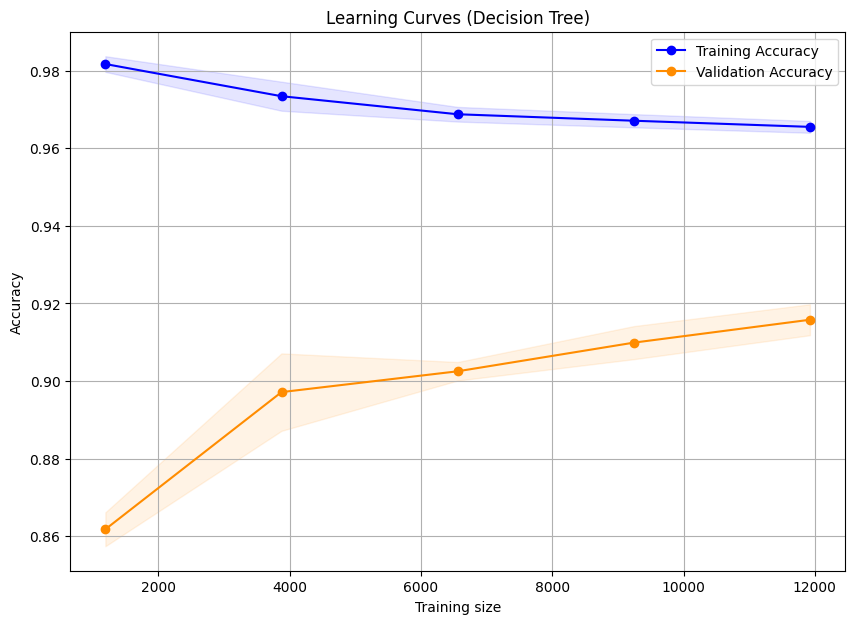

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define a function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training size")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="darkorange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training Accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="darkorange",
             label="Validation Accuracy")

    plt.legend(loc="best")
    return plt

# Plot learning curve
title = "Learning Curves (Decision Tree)"
estimator = best_clf_random  # Use the best model obtained from RandomizedSearchCV
plot_learning_curve(estimator, title, X_train, y_train, cv=5, n_jobs=-1)

plt.show()

# Effects of the regularizers

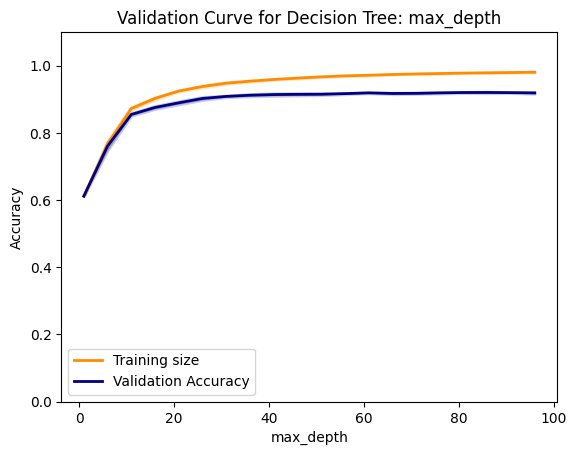

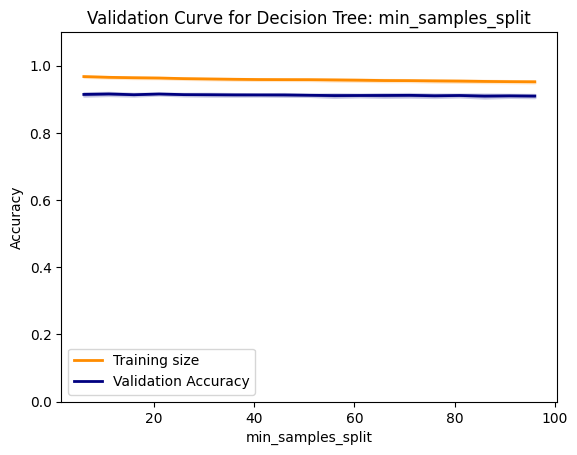

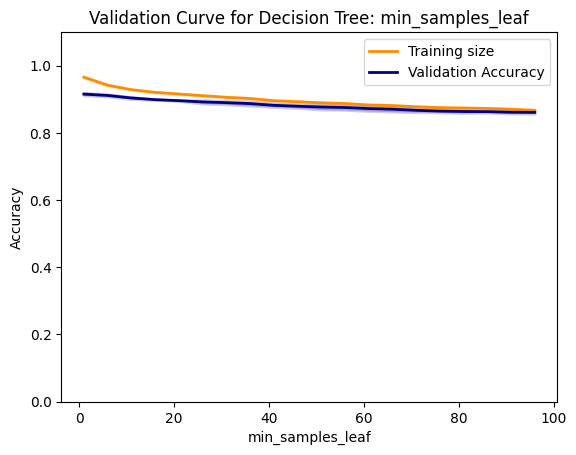

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Define the range of values for the regularizer you want to explore
param_range = np.arange(1, 101, 5)

# Define a function to plot validation curve
def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training size",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Validation Accuracy",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

# Plot validation curve for max_depth
title = "Validation Curve for Decision Tree: max_depth"
plot_validation_curve(best_clf_random, X_train, y_train, param_name="max_depth", param_range=param_range, title=title)
plt.show()

# Plot validation curve for min_samples_split
title = "Validation Curve for Decision Tree: min_samples_split"
plot_validation_curve(best_clf_random, X_train, y_train, param_name="min_samples_split", param_range=param_range, title=title)
plt.show()

# Plot validation curve for min_samples_leaf
title = "Validation Curve for Decision Tree: min_samples_leaf"
plot_validation_curve(best_clf_random, X_train, y_train, param_name="min_samples_leaf", param_range=param_range, title=title)
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, y_pred, target_names=['Safe Email', 'Phishing Email']))

                precision    recall  f1-score   support

    Safe Email       0.96      0.91      0.93      2209
Phishing Email       0.88      0.94      0.91      1518

      accuracy                           0.92      3727
     macro avg       0.92      0.93      0.92      3727
  weighted avg       0.92      0.92      0.92      3727



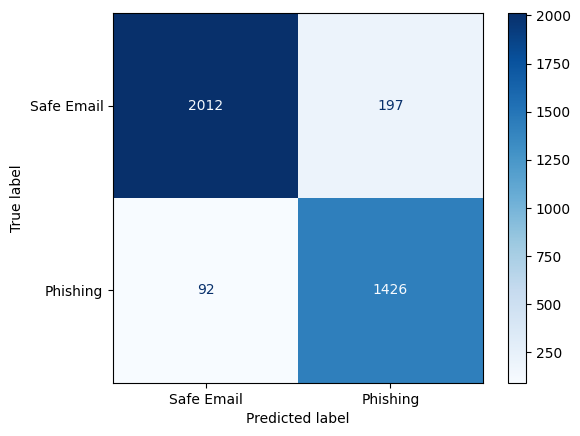

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from previous steps
# y_test: True labels of the test set
# y_pred: Predicted labels from the Decision Tree model

# Step: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe Email', 'Phishing'])
disp.plot(cmap=plt.cm.Blues)

# Display the plot
plt.show()

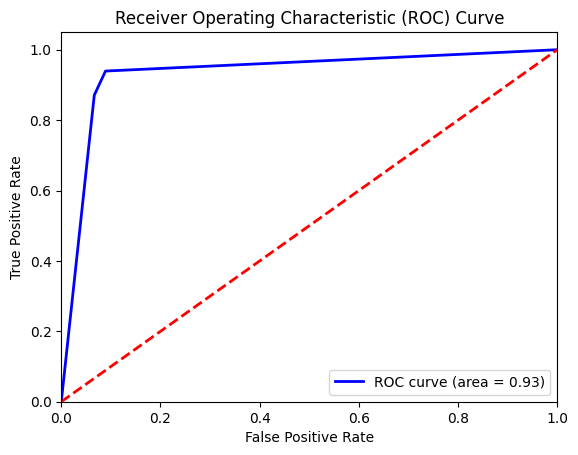

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Data cleaning
df.dropna(inplace=True)

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Email Text'])

# Encode the Email Type
y = df['Email Type'].factorize()[0]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

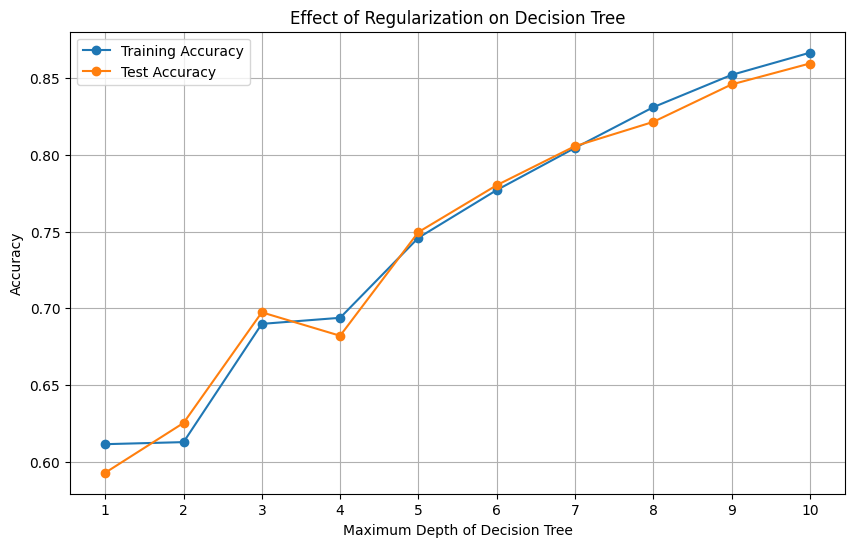

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Data cleaning
df.dropna(inplace=True)

# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Email Text'])

# Encode the Email Type
y = df['Email Type'].factorize()[0]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of maximum depths to test
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

train_scores = []
test_scores = []

# Train Decision Tree models with different maximum depths
for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    # Compute accuracy scores
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, '-o', label='Training Accuracy')
plt.plot(max_depths, test_scores, '-o', label='Test Accuracy')
plt.xlabel('Maximum Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Effect of Regularization on Decision Tree')
plt.xticks(max_depths)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import psutil

# Get CPU usage
cpu_usage = psutil.cpu_percent()
print(f'CPU Usage: {cpu_usage}%')

# Get memory usage
memory_info = psutil.virtual_memory()
print(f'Total Memory: {memory_info.total} bytes')
print(f'Used Memory: {memory_info.used} bytes')
print(f'Free Memory: {memory_info.available} bytes')

# Get GPU information (if available)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

CPU Usage: 76.0%
Total Memory: 13609435136 bytes
Used Memory: 2252779520 bytes
Free Memory: 11020746752 bytes


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6582810961198798350
 xla_global_id: -1]

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import psutil
import time

# Function to monitor resource usage
def monitor_resources():
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    return cpu_usage, memory_info.used / (1024 ** 3)  # Convert bytes to GB

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/CSE445/Phishing_Email.csv')

# Data Cleaning and Preparation
df.dropna(inplace=True)

# Converting text data into numerical format using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Email Text'])

# Encode the Email Type (target variable)
y = df['Email Type'].factorize()[0]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Monitor resources before training
cpu_before, ram_before = monitor_resources()
start_time = time.time()

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Monitor resources after training
cpu_after, ram_after = monitor_resources()
end_time = time.time()

# Print resource usage
print(f'CPU usage before training: {cpu_before}%')
print(f'RAM usage before training: {ram_before:.2f} GB')
print(f'CPU usage after training: {cpu_after}%')
print(f'RAM usage after training: {ram_after:.2f} GB')
print(f'Total training time: {end_time - start_time:.2f} seconds')

# Print the best parameters and best score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

# Evaluate the best model on the test set
best_clf_random = random_search.best_estimator_
y_pred_random = best_clf_random.predict(X_test)
test_accuracy_random = accuracy_score(y_test, y_pred_random)

print(f'Best Hyperparameters (RandomizedSearchCV): {best_params_random}')
print(f'Best Cross-Validation Accuracy (RandomizedSearchCV): {best_score_random}')
print(f'Test Accuracy (RandomizedSearchCV): {test_accuracy_random}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


CPU usage before training: 3.0%
RAM usage before training: 2.12 GB
CPU usage after training: 2.0%
RAM usage after training: 2.26 GB
Total training time: 664.72 seconds
Best Hyperparameters (RandomizedSearchCV): {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
Best Cross-Validation Accuracy (RandomizedSearchCV): 0.9169517158862828
Test Accuracy (RandomizedSearchCV): 0.9168231821840622
